<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [12]:
import os
import json
from functools import reduce
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

In [53]:
FOLDER = 'srad'
FILE = 'kernel_gpu_opencl' + '.cl'
KERNEL = 'compress_kernel'

stored_results = list(filter(
    lambda x : x.startswith(f'{FOLDER}__{FILE}__{KERNEL}__'),
    os.listdir('../desk/outputs')
))
stored_results.sort(key=lambda name : int(name.split('__')[3].split('.')[0]))

gsizes = sorted(map(lambda x : int(x.split('__')[3].split('.')[0]), stored_results))

In [54]:
# create result_dicts, a list of all the dicts stored in the file system,
# one dict for each 100-sample experiment

result_dicts = []
for d in stored_results:
    with open('../desk/outputs/' + d, 'r') as f:
        result_dicts.append(json.load(f))

print('Number of result dicts:', len(result_dicts))
# print('One of them looks like this:')
# pprint(result_dicts[-1])

Number of result dicts: 803


In [55]:
# reduce result_dicts to a averaged_result_dicts list,

samples = 100

def average_instcounts(d):
    
    def kinda_add_counters(a, b):
        a.update(b)
        return a

    d['results'] = dict(
        reduce(kinda_add_counters, map(Counter, map(lambda x : x['instcounts'], d['results'])))
    )
    d['results'] = {
        k : v // samples for k, v in d['results'].items()
    }
    return d

averaged_result_dicts = list(map(average_instcounts, result_dicts))

print('Number of averaged result dicts:', len(averaged_result_dicts))
# print('One of them looks like this:')
# pprint(averaged_result_dicts[-1])

Number of averaged result dicts: 803


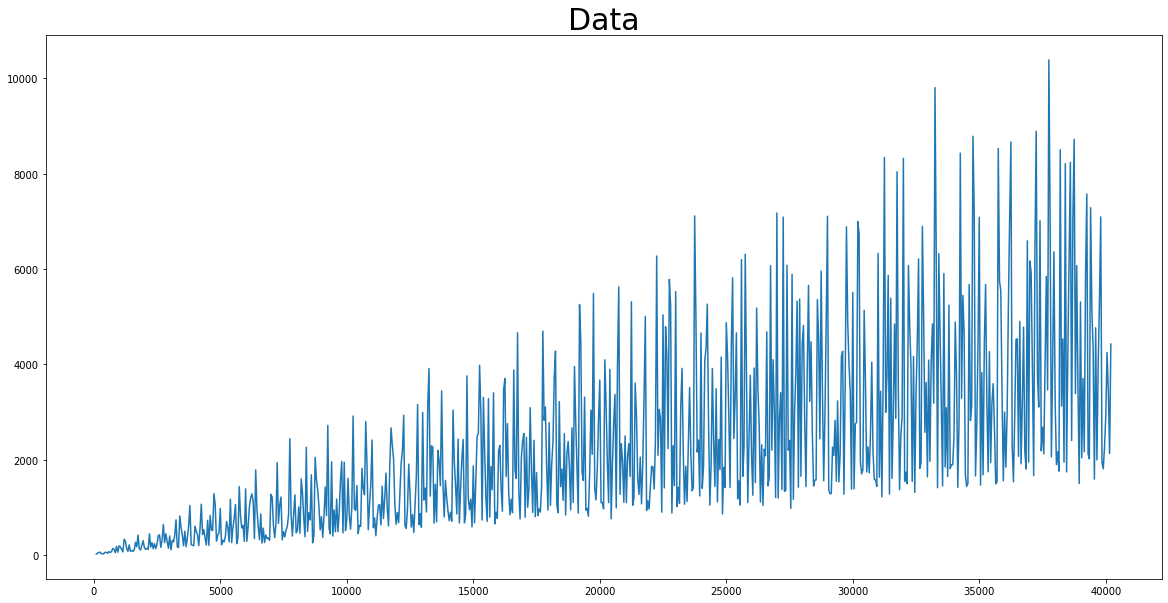

In [56]:
X = gsizes
y = list(map(lambda x : x['results']['store global'], averaged_result_dicts))
X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

plt.figure(figsize=(20, 10))
plt.title('Data', fontsize=30)
plt.plot(X, y)

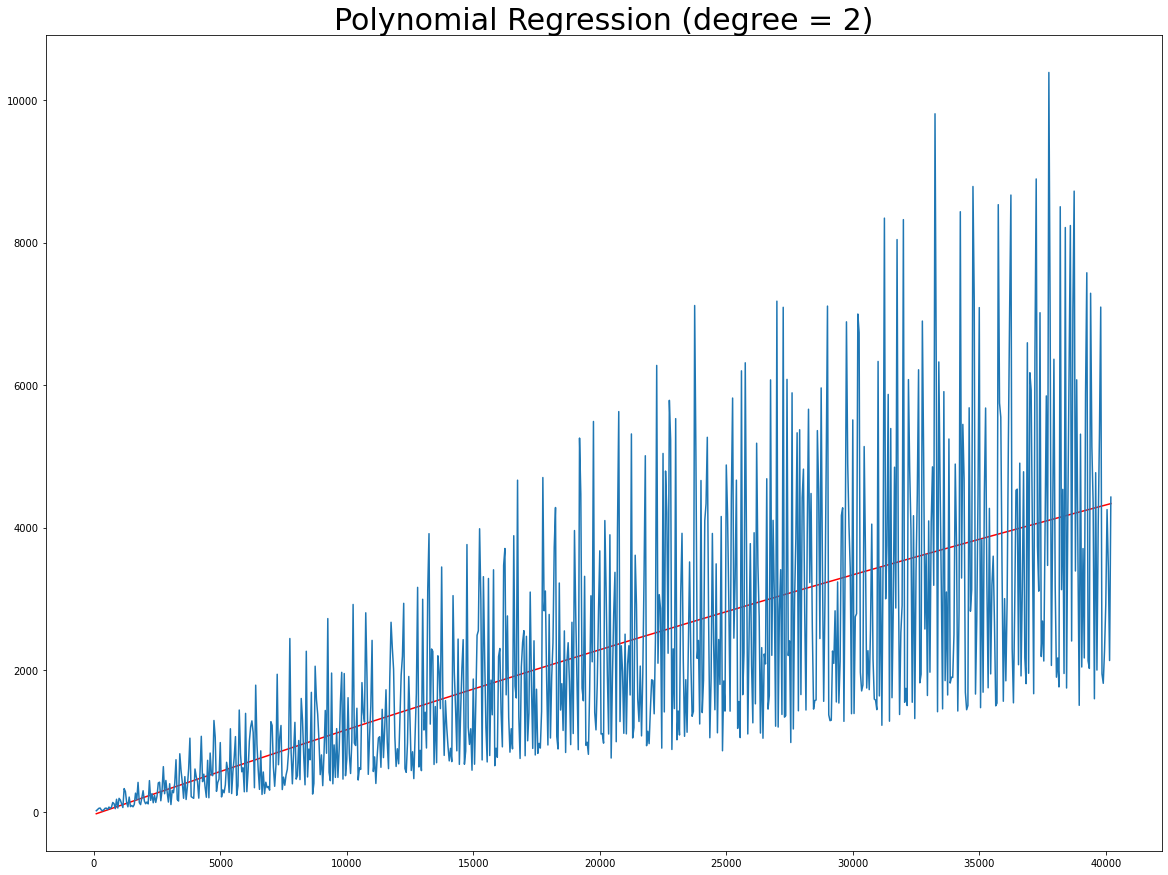

In [59]:
DEG=2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegression(LinearRegression):

    def __init__(self, degree):
        self.polynomial_features = PolynomialFeatures(degree=degree)
        super().__init__()

    def fit(self, x, y):
        x_poly = self.polynomial_features.fit_transform(x)
        return super().fit(x_poly, y)

    def predict(self, x):
        x_poly = self.polynomial_features.fit_transform(x)
        return super().predict(x_poly)

model = PolynomialRegression(degree=2)
model.fit(X, y)
y_poly_pred = model.predict(X)

plt.figure(figsize=(20, 15))
plt.title(f'Polynomial Regression (degree = {DEG})', fontsize=30)
plt.plot(X, y_poly_pred, color='r')
plt.plot(X, y)

plt.show()

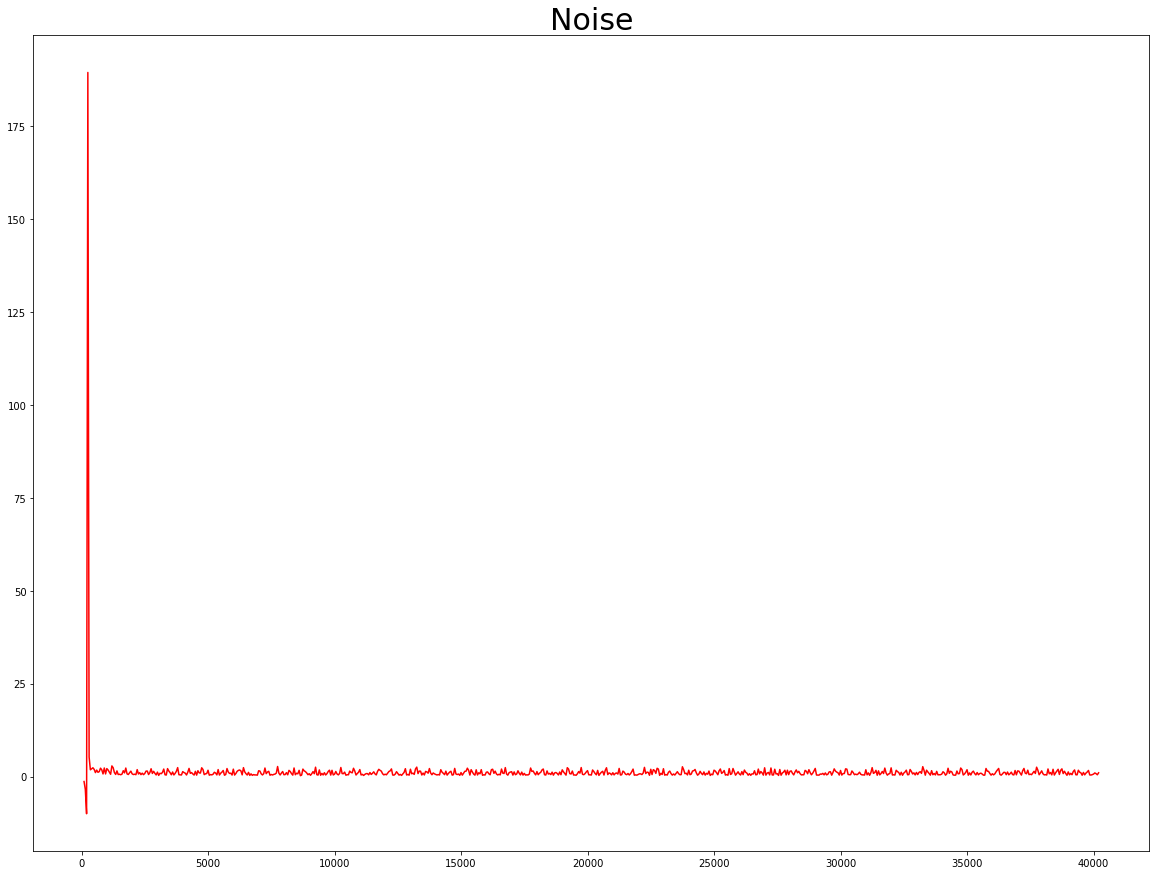

In [67]:
noise = y / y_poly_pred

plt.figure(figsize=(20, 15))
plt.title('Noise', fontsize=30)
plt.plot(X, noise, color='r')
#plt.plot(X, np.log(y), color='r')
plt.show()

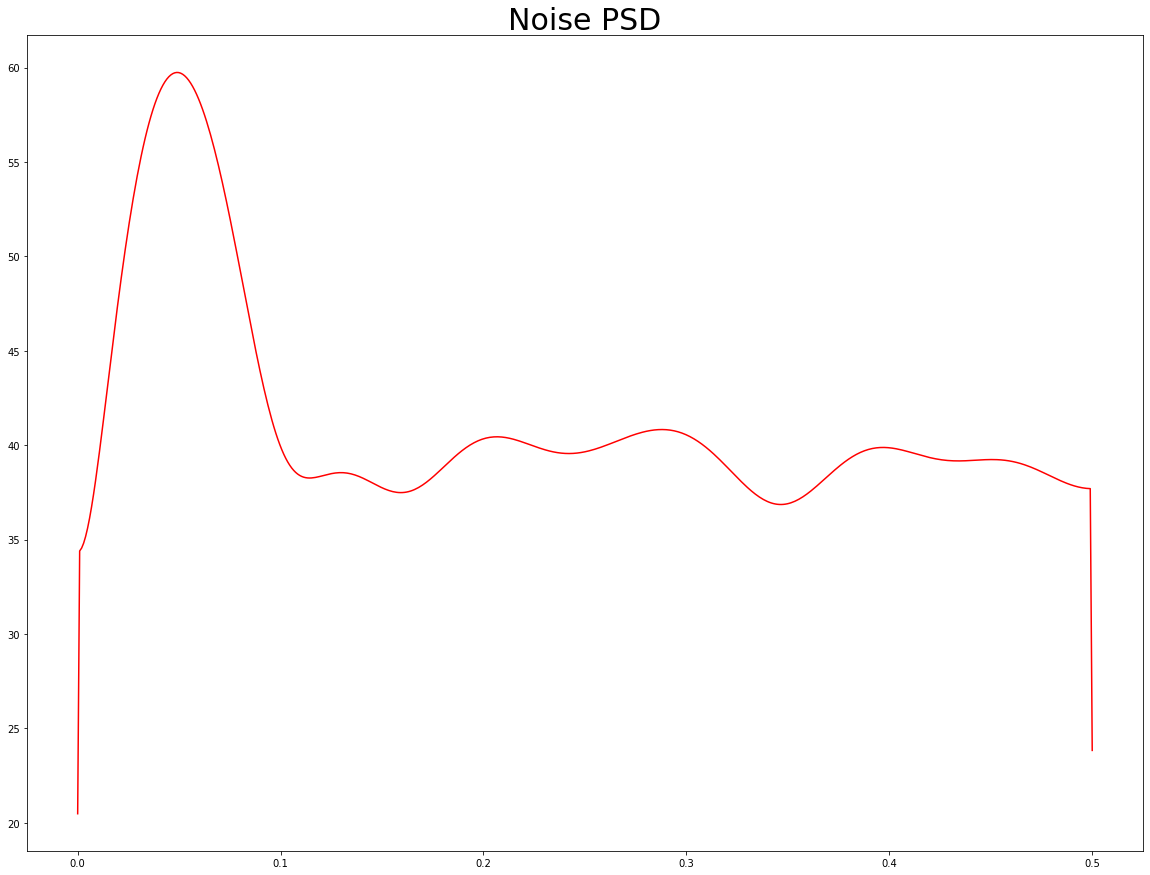

In [65]:
from scipy.signal import welch
from scipy.signal import windows

window = windows.hann(20)
f, psd = welch(noise.reshape(-1), window=window, noverlap=10, nfft=1024)

plt.figure(figsize=(20, 15))
plt.title('Noise PSD', fontsize=30)
plt.plot(f, 20*np.log(psd), color='r')
plt.show()